# FPT - Forecasting

## 1. Import libraries

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()




Instructions for updating:
non-resource variables are not supported in the long term


## 2. Read CSV and data processing

In [3]:
df = pd.read_csv('FPT.csv')

In [4]:
def process_dataframe(df):
    df = df[['Date/Time', 'Close']]

    df['Date/Time'] = pd.to_datetime(df['Date/Time'])

    df['Date'] = df['Date/Time'].dt.date

    df = df.groupby('Date').apply(lambda x: x.iloc[[0, -1]]).reset_index(drop=True)

    df.drop(columns=['Date/Time'], inplace=True)

    df['Date'] = pd.to_datetime(df['Date'])

    df.set_index('Date', inplace=True)

    df['Close'] = df['Close'] - df['Close'].shift(1)

    df = df.dropna()

    return df
df = process_dataframe(df)

In [5]:
minmax = MinMaxScaler().fit(df.iloc[:, 0:1].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 0:1].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.491396
1,0.621415
2,0.493308
3,0.650096
4,0.478011


## 3. Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times.

In [6]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((997, 1), (967, 1), (30, 1))

# 4. Training Model 
1. LSTM
2. Bidirectional- LSTM
3. LSTM - 2 path
4. GRU
5. Bidirectional- GRU

In [7]:
#LSTM
# Tắt eager execution
tf.compat.v1.disable_eager_execution()

class Model_lstm:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [8]:
# Bidirectional-LSTM
# Tắt eager execution
tf.compat.v1.disable_eager_execution()
class Model_bi_lstm:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.nn.rnn_cell.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.nn.rnn_cell.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [9]:
#LSTM - 2 path
class Model_lstm_2p:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.nn.rnn_cell.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.nn.rnn_cell.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [10]:
# GRU
class Model_gru:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [11]:
# Bidirectional-GRU
class Model_bi_gru:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.nn.rnn_cell.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.nn.rnn_cell.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [12]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 200
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [13]:
def forecast_lstm():
    tf.reset_default_graph()
    modelnn = Model_lstm(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [14]:
def forecast_bi_lstm():
    tf.reset_default_graph()
    modelnn = Model_bi_lstm(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [15]:
def forecast_lstm_2p():
    tf.reset_default_graph()
    modelnn = Model_lstm_2p(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))
        
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [16]:
def forecast_gru():
    tf.reset_default_graph()
    modelnn = Model_gru(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [17]:
def forecast_bi_gru():
    tf.reset_default_graph()
    modelnn = Model_bi_gru(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [18]:
def run_simulation(simulation_size, forecast_functions):
    results = []
    for i in range(simulation_size):
        print('simulation %d' % (i + 1))
        results.append([forecast() for forecast in forecast_functions])
    return results

forecast_functions = [forecast_lstm, forecast_bi_lstm, forecast_lstm_2p, forecast_gru, forecast_bi_gru]

all_results = run_simulation(simulation_size, forecast_functions)

results_lstm, results_bi_lstm, results_lstm_2p, results_gru, results_bi_gru = zip(*all_results)

simulation 1

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



train loop: 100%|██████████| 200/200 [02:49<00:00,  1.18it/s, acc=94.4, cost=0.00939]


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


train loop: 100%|██████████| 200/200 [03:49<00:00,  1.15s/it, acc=96.5, cost=0.00398]


train loop: 100%|██████████| 200/200 [04:14<00:00,  1.27s/it, acc=94.4, cost=0.00888]


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


train loop: 100%|██████████| 200/200 [02:57<00:00,  1.13it/s, acc=90.7, cost=0.0236]


train loop: 100%|██████████| 200/200 [03:45<00:00,  1.13s/it, acc=94, cost=0.0108]   


simulation 2


train loop: 100%|██████████| 200/200 [03:08<00:00,  1.06it/s, acc=94.4, cost=0.00922]


train loop: 100%|██████████| 200/200 [05:15<00:00,  1.58s/it, acc=96.2, cost=0.00516]


train loop: 100%|██████████| 200/200 [05:07<00:00,  1.54s/it, acc=94.6, cost=0.00844]


train loop: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s, acc=89.7, cost=0.0288]


train loop: 100%|██████████| 200/200 [04:56<00:00,  1.48s/it, acc=92.2, cost=0.0208] 


simulation 3


train loop: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it, acc=94.4, cost=0.00922]


train loop: 100%|██████████| 200/200 [05:36<00:00,  1.68s/it, acc=95.9, cost=0.00567]


train loop: 100%|██████████| 200/200 [04:55<00:00,  1.48s/it, acc=94.6, cost=0.00827]


train loop: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it, acc=94, cost=0.011]   


train loop: 100%|██████████| 200/200 [04:32<00:00,  1.36s/it, acc=90.6, cost=0.0277] 


simulation 4


train loop: 100%|██████████| 200/200 [03:04<00:00,  1.09it/s, acc=94.4, cost=0.00929]


train loop: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it, acc=96.4, cost=0.00454]


train loop: 100%|██████████| 200/200 [04:25<00:00,  1.33s/it, acc=94.8, cost=0.00783]


train loop: 100%|██████████| 200/200 [03:04<00:00,  1.09it/s, acc=93.5, cost=0.0126]


train loop: 100%|██████████| 200/200 [03:46<00:00,  1.13s/it, acc=95.2, cost=0.00711]


simulation 5


train loop: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s, acc=94.4, cost=0.0095] 


train loop: 100%|██████████| 200/200 [04:00<00:00,  1.20s/it, acc=96.6, cost=0.00385]


train loop: 100%|██████████| 200/200 [03:58<00:00,  1.19s/it, acc=94.7, cost=0.00847]


train loop: 100%|██████████| 200/200 [02:40<00:00,  1.25it/s, acc=85.8, cost=0.0538]


train loop: 100%|██████████| 200/200 [03:52<00:00,  1.16s/it, acc=95.1, cost=0.0076] 


simulation 6


train loop: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s, acc=94.4, cost=0.00946]


train loop: 100%|██████████| 200/200 [04:12<00:00,  1.26s/it, acc=96, cost=0.00515]  


train loop: 100%|██████████| 200/200 [03:47<00:00,  1.14s/it, acc=94.7, cost=0.0083] 


train loop: 100%|██████████| 200/200 [02:44<00:00,  1.21it/s, acc=92.2, cost=0.0176]


train loop: 100%|██████████| 200/200 [03:40<00:00,  1.10s/it, acc=95.1, cost=0.00751]


simulation 7


train loop: 100%|██████████| 200/200 [02:49<00:00,  1.18it/s, acc=94.4, cost=0.00922]


train loop: 100%|██████████| 200/200 [03:50<00:00,  1.15s/it, acc=96.5, cost=0.00407]


train loop: 100%|██████████| 200/200 [04:13<00:00,  1.27s/it, acc=94.5, cost=0.00903]


train loop: 100%|██████████| 200/200 [03:04<00:00,  1.08it/s, acc=86.4, cost=0.0616]


train loop: 100%|██████████| 200/200 [03:51<00:00,  1.16s/it, acc=93.9, cost=0.0125] 


simulation 8


train loop: 100%|██████████| 200/200 [02:42<00:00,  1.23it/s, acc=94.4, cost=0.00966]


train loop: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it, acc=96.2, cost=0.00507]


train loop: 100%|██████████| 200/200 [04:31<00:00,  1.36s/it, acc=94.6, cost=0.0085] 


train loop: 100%|██████████| 200/200 [02:55<00:00,  1.14it/s, acc=87.5, cost=0.0419]


train loop: 100%|██████████| 200/200 [04:10<00:00,  1.25s/it, acc=94.9, cost=0.00795]


simulation 9


train loop: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it, acc=94.4, cost=0.00947]


train loop: 100%|██████████| 200/200 [04:38<00:00,  1.39s/it, acc=95.8, cost=0.00559]


train loop: 100%|██████████| 200/200 [03:56<00:00,  1.18s/it, acc=94.6, cost=0.0085] 


train loop: 100%|██████████| 200/200 [02:53<00:00,  1.15it/s, acc=90.3, cost=0.0263]


train loop: 100%|██████████| 200/200 [03:58<00:00,  1.19s/it, acc=93.6, cost=0.0143] 


simulation 10


train loop: 100%|██████████| 200/200 [03:02<00:00,  1.10it/s, acc=94.4, cost=0.00958]


train loop: 100%|██████████| 200/200 [05:14<00:00,  1.57s/it, acc=96.4, cost=0.0042] 


train loop: 100%|██████████| 200/200 [07:01<00:00,  2.11s/it, acc=94.7, cost=0.008]  


train loop: 100%|██████████| 200/200 [05:27<00:00,  1.64s/it, acc=89.6, cost=0.0298]


train loop: 100%|██████████| 200/200 [06:03<00:00,  1.82s/it, acc=95.1, cost=0.00716]


In [19]:
def plot_forecasts_and_actual(results, actual_values, title=''):
    plt.figure(figsize=(15, 5))
    for no, r in enumerate(results):
        plt.plot(r, label='forecast %d' % (no + 1))
    plt.plot(actual_values, label='true trend', c='black')
    plt.legend()
    plt.title(title)
    plt.show()

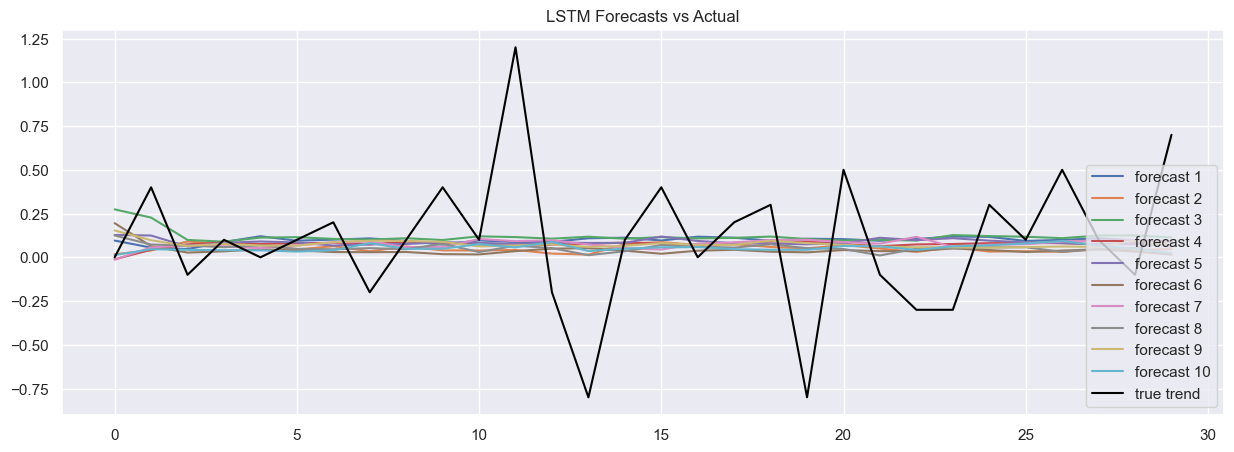

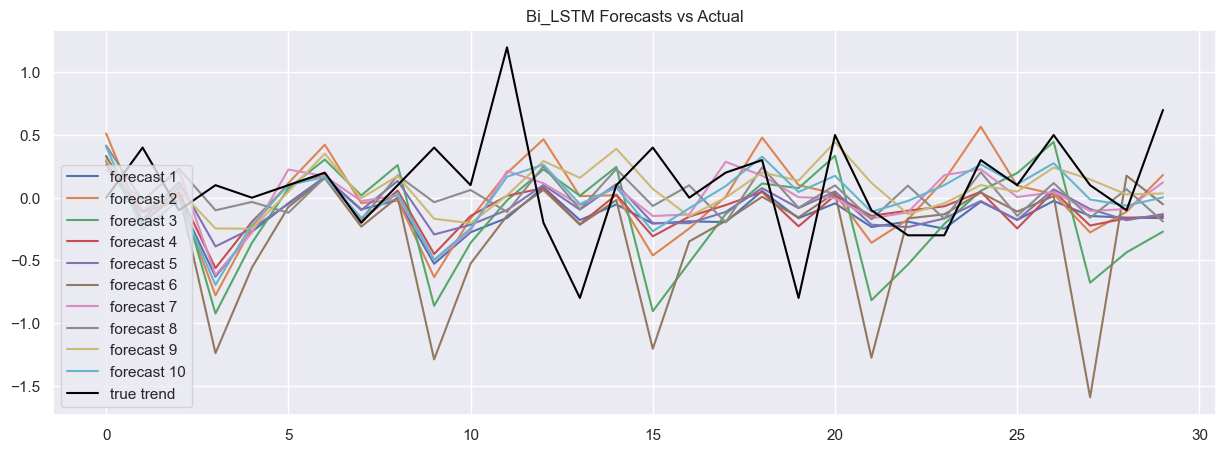

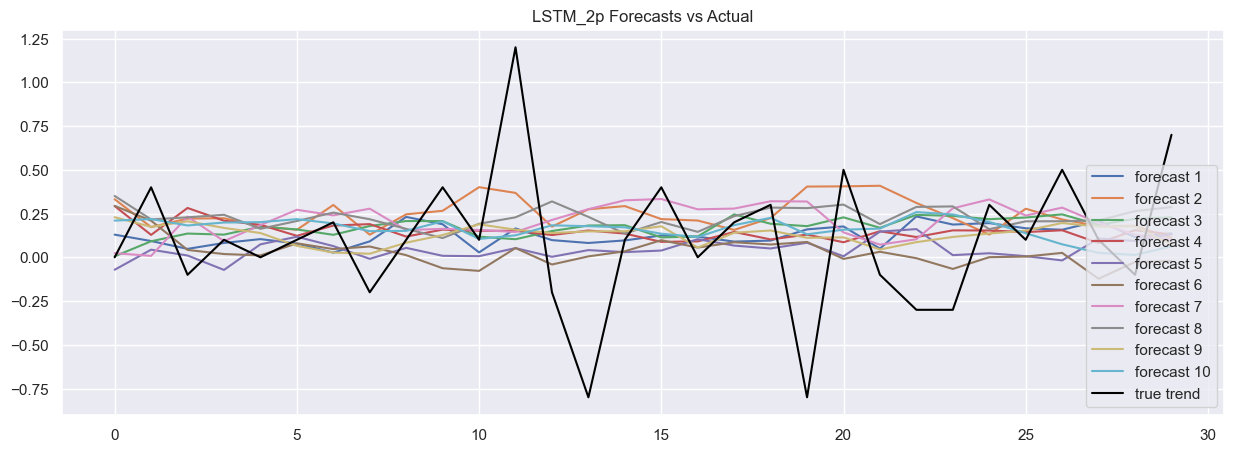

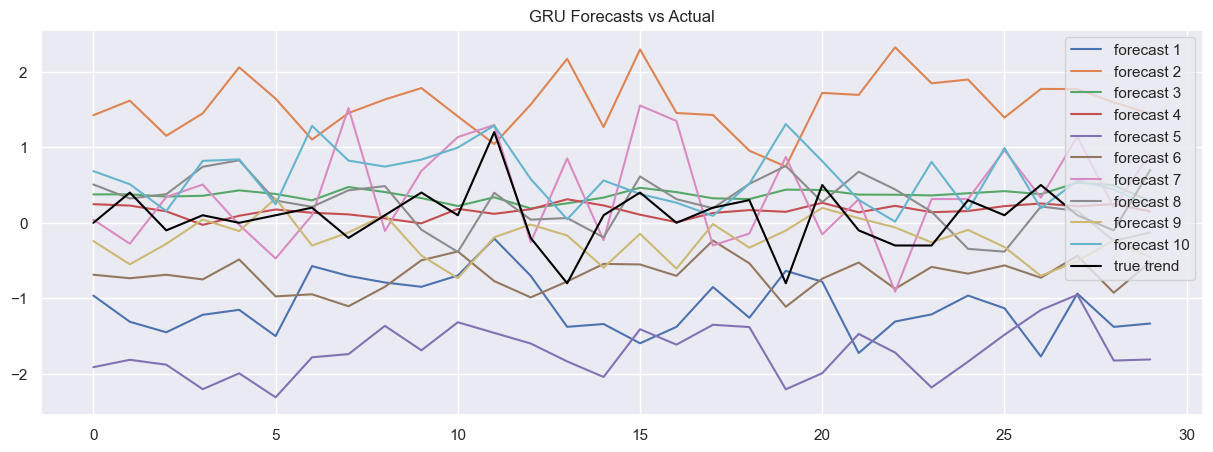

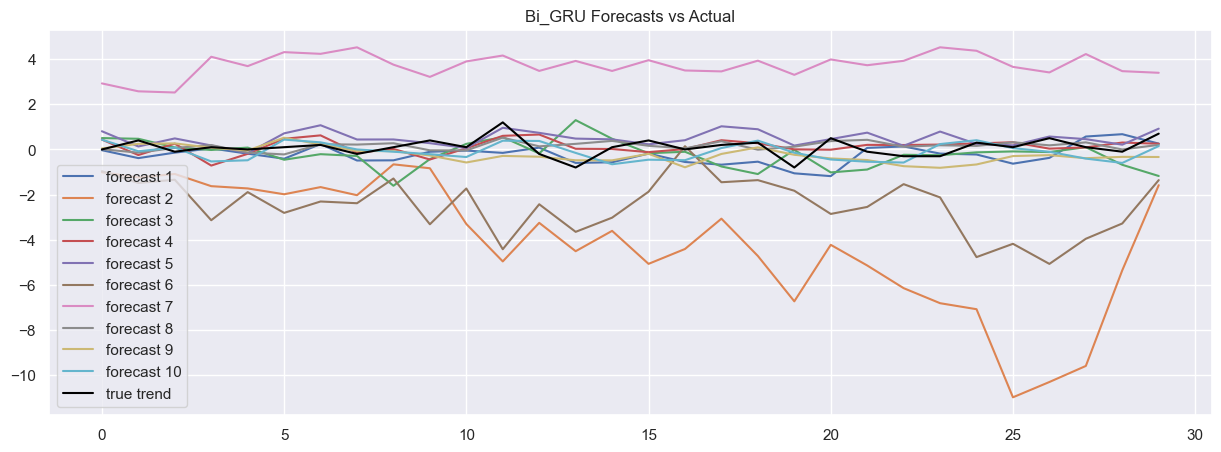

In [20]:
plot_forecasts_and_actual(results_lstm, df['Close'].iloc[-test_size:].values, title='LSTM Forecasts vs Actual')
plot_forecasts_and_actual(results_bi_lstm, df['Close'].iloc[-test_size:].values, title='Bi_LSTM Forecasts vs Actual')
plot_forecasts_and_actual(results_lstm_2p, df['Close'].iloc[-test_size:].values, title='LSTM_2p Forecasts vs Actual')
plot_forecasts_and_actual(results_gru, df['Close'].iloc[-test_size:].values, title='GRU Forecasts vs Actual')
plot_forecasts_and_actual(results_bi_gru, df['Close'].iloc[-test_size:].values, title='Bi_GRU Forecasts vs Actual')